In [4]:
import os
import glob
import nibabel as nib
import numpy as np
import cv2
import math

import matplotlib.pyplot as plt

In [9]:
data_path = '../data/all/'
os.listdir(data_path)

['VS-239-250',
 '.DS_Store',
 'VS-31-61',
 'VS-176-205',
 'VS-113-143',
 'VS-62-91',
 'README.md',
 'VS-206-238',
 'VS-1-30',
 'VS-144-175',
 'VS-92-112']

In [10]:
seg_list = sorted(glob.glob(os.path.join(data_path, 'VS-*-*/vs_*/*_seg_*')))

In [11]:
import plotly.express as px
import json

In [17]:
with open('../outputs/train_history.json', 'r') as f:
    train_history = json.load(f)
with open('../outputs/val_history.json', 'r') as f:
    val_history = json.load(f)

In [18]:
fig = px.line({'loss': train_history['loss'], 'val_loss': val_history['loss']})
fig.show()

In [19]:
fig = px.line({'dice': train_history['dice'], 'val_dice': val_history['dice']})
fig.show()

In [32]:
import sys

sys.path.append('../')
from src.model.correction_model import CorrectionUnet
from src.data.correction_generator import CorrectionMRIDataset, CorrectionDataloader

import torch

In [115]:
data = CorrectionMRIDataset(
    seg_list[:100], 
    (40, 256, 256),
    clicks = {
        'num': 3,
        'dst': 10
    },
    cuts = {
        'num': 12,
        'size': 32,
        'random': False,
    }
)

In [116]:
model = CorrectionUnet(
    in_channels=1, 
    out_channels=1, 
    blocks=3
).to('mps')

checkpoint = torch.load('../outputs/best.pt', map_location='mps')
model.load_state_dict(checkpoint['model_state'])

<All keys matched successfully>

In [117]:
len(data)

100

In [118]:
def plot_batched_cuts(cuts: torch.Tensor, cuts2, cuts3, cmap='magma'):
    rows = len(cuts)//4
    rows = rows if rows >= 4 else 4
    cols = 4
    res = cols if cols > rows else rows
    
    # Plot them
    fig, axs = plt.subplots(1, 3, figsize=(res*2, res*2))
    axs = axs.flatten()
    j = 0

    tmp_cut = torch.clone(cuts[0,0,:,:])
    tmp_cut[cuts.shape[2]//2, cuts.shape[2]//2] = 2
    axs[j].imshow(tmp_cut.cpu(), cmap=cmap)
    axs[j].axis('off')
    axs[j].set_title('correction', fontsize=9)
    
    tmp_cut = torch.clone(cuts2[0,0,:,:])
    tmp_cut[cuts.shape[2]//2, cuts.shape[2]//2] = 2
    axs[j+1].imshow(tmp_cut.cpu(), cmap=cmap)
    axs[j+1].axis('off')
    axs[j+1].set_title('gt', fontsize=9)

    tmp_cut = torch.clone(cuts3[0,0,:,:])
    tmp_cut[cuts.shape[2]//2, cuts.shape[2]//2] = 2
    axs[j+2].imshow(tmp_cut.cpu(), cmap=cmap)
    axs[j+2].axis('off')
    axs[j+2].set_title('training', fontsize=9)
    plt.show()   

1


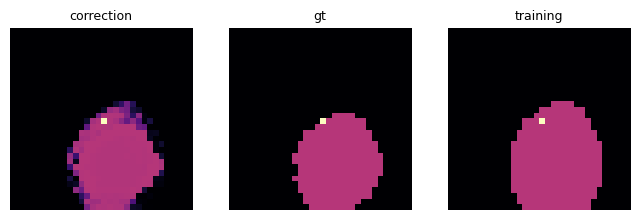

In [163]:
with torch.no_grad():
    dataloader = CorrectionDataloader(data, 1)
    for i, (x, y) in enumerate(dataloader):
        x, y = x.to('mps'), y.to('mps')
        y_pred = model(y)
        print(len(y_pred))
        plot_batched_cuts(y_pred, y, x)
        break
